(pde:fvm:poisson-1d)=
# 1-dimensional Poisson equation

## Integral form of the problem

The integral form of a Poisson problem reads, **for every** $V \in \Omega$,

$$- \oint_{\partial V} \hat{\mathbf{n}} \cdot \left( \nu \nabla u \right) = \int_{V} f \ .$$

supplied with proper boundary conditions. As an example, 
- Dirichlet boundary conditions: $u(\overline{x}) = \overline{u}$
- Neumann boundary conditions: $\nu \hat{\mathbf{n}} \cdot \nabla u(\overline{x}) = \overline{q}$
- Robin boundary conditions: $a u(\overline{x}) + b u'(\overline{x}) = c$

*The multi-dimensional set may be useful also for 1-dimensional domains, to avoid confusions with signs*




In [31]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

#> Domain
a, b = 0, 1
l = b - a

#> Physical properties
nu = .01                       # Diffusion coefficient
f = 1.

#> Discretization
nel = 10            # n.of elements
nnodes = nel + 1    # n.of nodes
nvol = nnodes       # n.finite volumes (node-centered FVM)

#> Dirichlet boundaries
i_dir = np.array([ 0, nvol-1])   # Global idx of nodes on Dirichlet boundaries
u_dir = np.array([ .0, .0 ])   # Value of the solution at nodes on Dir. boundaries

#> Volume forcing contribution
f_nodal = np.ones(nel+1) * f   # Nodal values f(x_i) of volume forcing, here uniform f(x) = f

#> Node centered FVM
rr_n = np.linspace(a,b, nel+1)       # node coordinates (center of the node-centered FVs) 
rr_i = .5 * ( rr_n[:-1] + rr_n[1:] ) # coords of the inner cell interface
rr_b = np.array([ 2*rr_n[0]-rr_n[1], 2*rr_n[-1]-rr_n[-2] ])  # coords of the boundaries

vols = np.array(
     [ np.abs(rr_i[0]-rr_n[0]) ] + \
       list( np.abs(rr_i[1:] - rr_i[:-1]) ) + \
     [ np.abs(rr_i[-1]-rr_n[-1]) ]
)

ni = len(rr_i)
nb = len(rr_b)

#> Interface-volume connectivity (ni, 2) (normal dir: first element -> second element)
iee = np.array([ [i, i+1] for i in np.arange(ni) ])
#> Boundary-volume connectivity (nb) (convention, normal dir: elem -> outside)
bee = np.array([0, nvol-1])


In [32]:
#> Evaluating boundary contributions
# Here assmbling a stiffness matrix. In many FVM applications, there's explicit time
# dependence and explicit time integration schemes are used, so there's no need to 
# assemble any matrix while the algorithm just rely on accumulation of flux contributions
# -> Add a link to a script implementing time-dependent "solver" for FVM, e.g. hyperbolic problems

i_flux, j_flux, e_flux = [], [], []

#> Loop over internal interface
# accumulating and keep changing the dimension! May be very inefficient and slow
for i in np.arange(ni):
    flux_u = nu / np.abs( rr_n[ iee[i,1] ] - rr_n[ iee[i,0] ] )
    i_flux += [ iee[i,0], iee[i,0], iee[i,1], iee[i,1] ]
    j_flux += [ iee[i,0], iee[i,1], iee[i,0], iee[i,1] ]
    e_flux += [ -flux_u, flux_u, flux_u, -flux_u ]

e_flux = -np.array(e_flux)

K = sp.sparse.coo_array((e_flux, (i_flux, j_flux)),)

#> Volume forcing
F = vols * f

#> Loop over boundary surfaces
# ...
# - Neumann: add a forcing term for finite volumes with sides on Neumann boundaries
# - Dirichlet: prescribe node value (e.g. 1) matrix slicing, 2) augmented system,...)
# - Robin: add a forcing term depending on the unknown value of the function -> modify K matrix

# ...



[ 0 10]
[1 2 3 4 5 6 7 8 9]


Text(0, 0.5, 'f(x)')

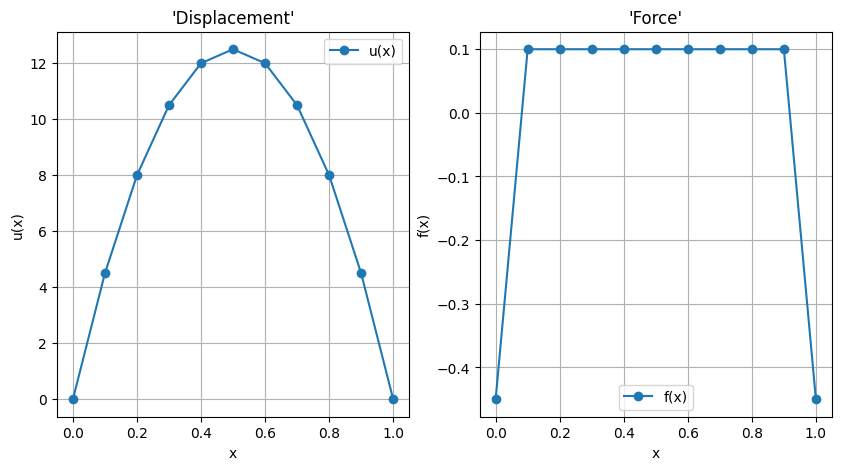

In [33]:
#> Apply essential boundary conditions, solve the linear system and retrieve the solution
#> Method 1. Slicing matrices
# K u = f
# [ Kuu  Kud ] [ uu ] = [ fu ]
# [ Kdu  Kdd ] [ ud ]   [ fd ]
# with known: ud, fu; unknown: uu, fd found solving the problem
# Kuu * uu = fuu - Kud * ud  -> uu = ...
# fd = Kdu * uu + Kdd * ud
iD = i_dir.copy()
iU = np.array(list(set(np.arange(nnodes)) - set(iD)))
ud = u_dir.copy()

print(iD)
print(iU)

#> Slice stiffness matrix
Kuu = (K.tocsc()[:,iU]).tocsr()[iU,:]
Kud = (K.tocsc()[:,iD]).tocsr()[iU,:]
Kdu = (K.tocsc()[:,iU]).tocsr()[iD,:]
Kdd = (K.tocsc()[:,iD]).tocsr()[iD,:]

#> Slice forcing
fu = F[iU]

#> Solve the linear system
uu = sp.sparse.linalg.spsolve(Kuu, fu - Kud @ ud )
fd = Kdu @ uu + Kdd @ ud

#> Re-assemble the solution
u = np.zeros(nnodes);  u[iU] = uu;  u[iD] = ud
f = np.zeros(nnodes);  f[iU] = fu;  f[iD] = fd
# print("uu: \n", uu)
# print("Fd: \n", fd)

#> Plot some results
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(rr_n, u, '-o', label='u(x)')
ax[0].legend()
ax[0].grid()
ax[0].set_title('\'Displacement\'')
ax[0].set_xlabel('x')
ax[0].set_ylabel('u(x)')
ax[1].plot(rr_n, f, '-o', label='f(x)')
ax[1].legend()
ax[1].grid()
ax[1].set_title('\'Force\'')
ax[1].set_xlabel('x')
ax[1].set_ylabel('f(x)')


In [34]:
#> Method 2. Augmented system
# ...


$$-\left(\nu \, u'(x) \right)' = f(x) \ , \quad x \in [a,b]$$


**Some comments and todos.**

* **Convergence analysis.** It's possible to evaluate both convergence with the dimension of the elements and/or the degree of the polynomial base functions. The *exact solution* can be easily computed analytically via direct integration for simple distribution of load $f(x)$, and uniform $\nu$
* **Result discussion.** "Force" contribution on Dirichlet boundary conditions involves both the node contribution to distributed load and the "constraint reaction". As an example, with a domain of size $\ell$ and uniform force distribution $f$, with $u(0) = u(\ell) = 0$, by *symmetry* and *global equilibrium* the force at boundaries are $-\frac{1}{2} q \ell = - \frac{1}{2}$. With the modelling choices done, the contribution of the uniform distributed load on an element on any of its nodes is $\frac{1}{2} q \ell_i = \frac{1}{2} q \frac{\ell}{n_{el}}$. Here with $n_{el} = 20$, this elementary contribution is $\frac{1}{40} = .025$: thus, the nodal contribution of internal nodes is twice (contribution from two neighboring elements) this value $.05$, and the force on each Dirichlet boundary is $-\frac{1}{2} + \frac{1}{40} = - 0.475$.
* Try to set different values of Dirichlet boundary conditions, u_dir